In [61]:
#Install the required libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
df = pd.read_excel('/content/Product Details.xlsx')
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [63]:
len(df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


541909

In [64]:
clean_df = df[(df['Quantity']>0) & (df['CustomerID']>0)]
clean_df.head()
missing_data = clean_df.isnull().sum()
missing_data, len(clean_df), clean_df.shape, clean_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(InvoiceNo      0
 StockCode      0
 Description    0
 Quantity       0
 InvoiceDate    0
 UnitPrice      0
 CustomerID     0
 Country        0
 dtype: int64,
 397924,
 (397924, 8),
   InvoiceNo StockCode                          Description  Quantity  \
 0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
 1    536365     71053                  WHITE METAL LANTERN         6   
 2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
 3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
 4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
 
           InvoiceDate  UnitPrice  CustomerID         Country  
 0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
 1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
 2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
 3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
 4 2010-12-01 08:26:00       3.39     17850.0  United King

Let's group the Description & Quantity to see the top products sold

In [72]:
top_prods = clean_df.groupby(['Description'])['Quantity'].sum().sort_values(ascending=False)
top_prods.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Quantity
Description,
"PAPER CRAFT , LITTLE BIRDIE",80995
MEDIUM CERAMIC TOP STORAGE JAR,77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS,54415
JUMBO BAG RED RETROSPOT,46181
WHITE HANGING HEART T-LIGHT HOLDER,36725
ASSORTED COLOUR BIRD ORNAMENT,35362
PACK OF 72 RETROSPOT CAKE CASES,33693
POPCORN HOLDER,30931
RABBIT NIGHT LIGHT,27202


Let's do RFM analysis and group customers. First, we put the invoice date in proper format & fetch the recent purchase date using max() func.
Group the 'invoice date' & 'customer ID', and we then use qcut to rank each RFM metric.

In [85]:
def calculate_rfm(clean_df):
  df_clean1 = clean_df.copy()
  df_clean1['InvoiceDate'] = pd.to_datetime(clean_df['InvoiceDate'])
  max_date = df_clean1['InvoiceDate'].max()

  rfm = clean_df.groupby('CustomerID').agg({
      'InvoiceDate': lambda x: (max_date - x.max()).days,
      'InvoiceNo' : 'nunique',
      'Quantity' : 'sum'
  }).reset_index()

  rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
  return rfm


def score(rfm):
    # Debugging: Check the number of unique values in each metric
    print("Unique values in Recency: ", rfm['Recency'].nunique())
    print("Unique values in Frequency: ", rfm['Frequency'].nunique())
    print("Unique values in Monetary: ", rfm['Monetary'].nunique())

    # Recency Score
    try:
        rfm['RecencyScore'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
    except ValueError as e:
        print(f"Error in Recency: {e}")
        rfm['RecencyScore'] = pd.cut(rfm['Recency'], bins=5, labels=[5, 4, 3, 2, 1], duplicates='drop')

    # Frequency Score
    try:
        rfm['FrequencyScore'] = pd.qcut(rfm['Frequency'], 5, labels=[1, 2, 3, 4, 5])
    except ValueError as e:
        print(f"Error in Frequency: {e}")
        rfm['FrequencyScore'] = pd.cut(rfm['Frequency'], bins=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

    # Monetary Score
    try:
        rfm['MonetaryScore'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])
    except ValueError as e:
        print(f"Error in Monetary: {e}")
        rfm['MonetaryScore'] = pd.cut(rfm['Monetary'], bins=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

    # Combine RFM Scores
    rfm['RFM_Score'] = rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str) + rfm['MonetaryScore'].astype(str)

    # Calculate total RFM score
    rfm['RFMScore'] = rfm[['RecencyScore', 'FrequencyScore', 'MonetaryScore']].sum(axis=1)

    return rfm

rfm = calculate_rfm(clean_df)
score = score(rfm)
score.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unique values in Recency:  349
Unique values in Frequency:  59
Unique values in Monetary:  1768
Error in Frequency: Bin edges must be unique: array([  1.,   1.,   2.,   3.,   6., 210.]).
You can drop duplicate edges by setting the 'duplicates' kwarg


,CustomerID,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score,RFMScore
0,12346.0,325,1,74215,1,1,5,115,7
1,12347.0,1,7,2458,5,1,5,515,11
2,12348.0,74,4,2341,2,1,5,215,8
3,12349.0,18,1,631,4,1,4,414,9
4,12350.0,309,1,197,1,1,2,112,4


Let's visualize the RFM outcomes.
How to interpret/ conclude:

*   The higher the value of Recency (1-5), the more recent the customer has purchased something from the store
*   The higher the number (1-5), the frequent the customer is
*   The higher the monetary score (1-5), the higher the customers are spending at your store





/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


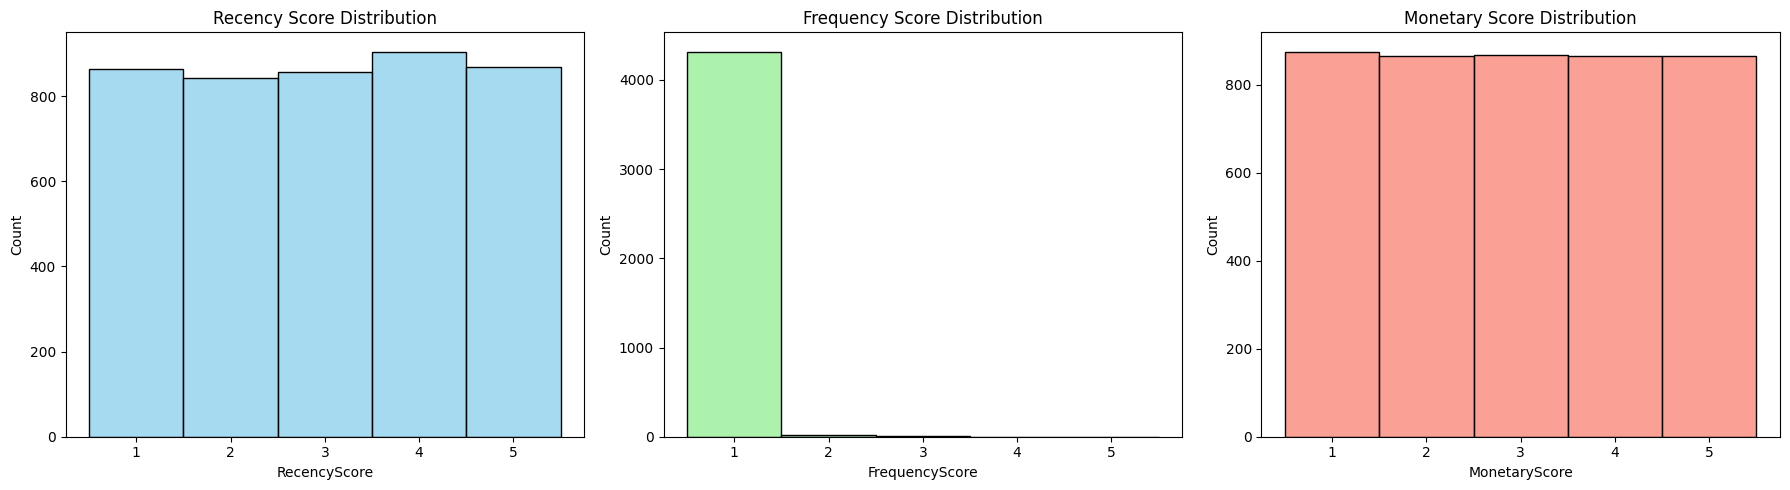

<ipython-input-87-1f9a1cb42be1>:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm_segment_counts = rfm.groupby(['RecencyScore', 'FrequencyScore', 'MonetaryScore']).size().unstack(fill_value=0)


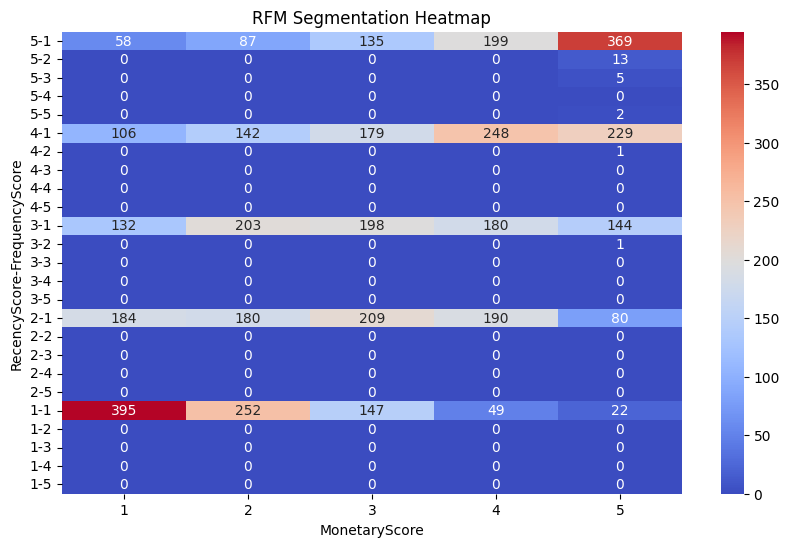

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_rfm(rfm):
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    sns.histplot(rfm['RecencyScore'], kde=False, bins=5, color='skyblue')
    plt.title('Recency Score Distribution')

    plt.subplot(1, 3, 2)
    sns.histplot(rfm['FrequencyScore'], kde=False, bins=5, color='lightgreen')
    plt.title('Frequency Score Distribution')

    plt.subplot(1, 3, 3)
    sns.histplot(rfm['MonetaryScore'], kde=False, bins=5, color='salmon')
    plt.title('Monetary Score Distribution')

    plt.tight_layout()
    plt.show()

    # 2. RFM Segmentation Heatmap
    plt.figure(figsize=(10, 6))
    rfm_segment_counts = rfm.groupby(['RecencyScore', 'FrequencyScore', 'MonetaryScore']).size().unstack(fill_value=0)

    sns.heatmap(rfm_segment_counts, annot=True, fmt='d', cmap='coolwarm')
    plt.title('RFM Segmentation Heatmap')
    plt.show()

visualize_rfm(rfm)  # Calling the visualization function


Most & Least Sold Items

In [102]:
most_sold = clean_df.groupby(['Description']).agg({
    'Quantity' : 'sum'
}).sort_values('Quantity', ascending=False)
least_sold = clean_df.groupby(['Description']).agg({
    'Quantity' : 'sum'
}).sort_values('Quantity', ascending=True)

print (f"Most sold item is : {most_sold.index[0]} with a quantity of {most_sold.iloc[0]['Quantity']}")
print (f"Least sold item is : {least_sold.index[0]} with a quantity of {least_sold.iloc[0]['Quantity']}")

Most sold item is : PAPER CRAFT , LITTLE BIRDIE with a quantity of 80995
Least sold item is : SET OF 3 PINK FLYING DUCKS with a quantity of 1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Low Satisfactory Products. Let's just define the products that having less than 6 RFM Score are the low satisfactory products.

In [119]:
print (f"{rfm['RFMScore'].max()} is the highest RFM Score")
print (f"{rfm['RFMScore'].min()} is the lowest RFM Score")

15 is the highest RFM Score
3 is the lowest RFM Score


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [132]:
lowrfm_customers = rfm[rfm['RFMScore'] <= 6]
lowrfm_transactions = clean_df[clean_df['CustomerID'].isin(lowrfm_customers['CustomerID'])]
products_withlowrfm = lowrfm_transactions.groupby('Description').agg({
    'Quantity' : 'sum'
}).sort_values('Quantity', ascending=True)
products_withlowrfm.head(20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3358

total 3358 low rfm products are there

In [135]:
least_sold_3358 = least_sold.index[0:3358]
print (f"Least sold items are : {least_sold.index[0:3358]} with a quantity of {least_sold.iloc[0:3358]['Quantity']}")

Least sold items are : Index(['SET OF 3 PINK FLYING DUCKS', 'DOLPHIN WINDMILL',
       'CRACKED GLAZE EARRINGS BROWN', 'LASER CUT MULTI STRAND NECKLACE',
       'SET/3 TALL GLASS CANDLE HOLDER PINK', 'CHERRY BLOSSOM PURSE',
       'HEN HOUSE W CHICK IN NEST', 'CAKE STAND LACE WHITE',
       'MARIE ANTOIENETT TRINKET BOX GOLD', 'MUMMY MOUSE RED GINGHAM RIBBON',
       ...
       'PACK OF 6 COCKTAIL PARASOL STRAWS', 'GLITTER CHRISTMAS STAR ',
       'VINTAGE CHRISTMAS CAKE FRILL', 'SCANDINAVIAN PAISLEY PICNIC BAG',
       'KNITTED UNION FLAG HOT WATER BOTTLE', 'SET OF 4 JAM JAR MAGNETS',
       'MINI PLAYING CARDS DOLLY GIRL ', 'CHILDRENS CUTLERY RETROSPOT RED ',
       'SET/20 STRAWBERRY PAPER NAPKINS ', 'MUSICAL ZINC HEART DECORATION '],
      dtype='object', name='Description', length=3358) with a quantity of Description
SET OF 3 PINK FLYING DUCKS                1
DOLPHIN WINDMILL                          1
CRACKED GLAZE EARRINGS BROWN              1
LASER CUT MULTI STRAND NECKLACE   

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [137]:
low_rfm_products_df = products_withlowrfm.reset_index()

least_sold_products_df = pd.DataFrame(least_sold_3358).reset_index()

# Display both DataFrames
print("Low RFM Products:")
print(low_rfm_products_df.head())

print("Least Sold Products:")
print(least_sold_products_df.head())


Low RFM Products:
                           Description  Quantity
0       BLUE WIRE SPIRAL CANDLE HOLDER         1
1   BLUE ORGANDY ROUND LAMPSHADE W BEA         1
2           BLUE MURANO TWIST NECKLACE         1
3           BLUE MURANO TWIST BRACELET         1
4  SILVER 2 STRAND NECKLACE-LEAF CHARM         1
Least Sold Products:
   index                          Description
0      0           SET OF 3 PINK FLYING DUCKS
1      1                     DOLPHIN WINDMILL
2      2         CRACKED GLAZE EARRINGS BROWN
3      3      LASER CUT MULTI STRAND NECKLACE
4      4  SET/3 TALL GLASS CANDLE HOLDER PINK


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [139]:
common_items = pd.merge(low_rfm_products_df, least_sold_products_df, on='Description', suffixes=('_low_rfm', '_least_sold'))
print("Common items between Low RFM products and Least Sold products:")
print(common_items)


Common items between Low RFM products and Least Sold products:
                              Description  Quantity  index
0          BLUE WIRE SPIRAL CANDLE HOLDER         1    404
1      BLUE ORGANDY ROUND LAMPSHADE W BEA         1    463
2              BLUE MURANO TWIST NECKLACE         1    178
3              BLUE MURANO TWIST BRACELET         1    620
4     SILVER 2 STRAND NECKLACE-LEAF CHARM         1     60
...                                   ...       ...    ...
2837      CANDLEHOLDER PINK HANGING HEART       463   3234
2838           PARTY CONES CANDY ASSORTED       468   3100
2839           METAL TUBE CHIME ON BAMBOO       469   2169
2840     SET/20 STRAWBERRY PAPER NAPKINS        511   3356
2841       EMBOSSED GLASS TEALIGHT HOLDER       584   3323

[2842 rows x 3 columns]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **The above list of products are underperforming that both low RFM customers are buying and that have low sales overall.**

In [140]:
common_items.to_csv('common_low_rfm_least_sold.csv', index=False)
print("Common items saved to 'common_low_rfm_least_sold.csv'.")

Common items saved to 'common_low_rfm_least_sold.csv'.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
